## Anomaly Detection - Project
### Authors: Norbert Klockiewicz, Kacper Majchrzak, Patryk Kożuch

#### Based on: <a href="https://arxiv.org/pdf/1802.04431.pdf">Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding</a>

Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools as mit
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping
from keras.layers import Dense, Activation, Dropout, LSTM

In [2]:
CHANNEL = "A-1"

### Class channel - load and prepare data to train model

In [3]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [4]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

### Class Model - create and train recurrent neural network

In [5]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [6]:
model = Model(new_channel)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-03-16 14:31:32.164807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 14:31:32.165212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/35


2024-03-16 14:31:32.799659: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-16 14:31:34.242282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:31:34.549902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:31:36.608137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:31:38.657412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:32:03.231669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - ETA: 0s - loss: 0.2626

2024-03-16 14:33:32.589823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:33:32.739358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:33:35.008323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 129s 2s/step - loss: 0.2626 - val_loss: 0.0077
Epoch 2/35
33/33 [==============================] - 6s 192ms/step - loss: 0.0390 - val_loss: 0.0020
Epoch 3/35
33/33 [==============================] - 5s 159ms/step - loss: 0.0236 - val_loss: 0.0015
Epoch 4/35
33/33 [==============================] - 5s 164ms/step - loss: 0.0170 - val_loss: 0.0011
Epoch 5/35
33/33 [==============================] - 5s 160ms/step - loss: 0.0126 - val_loss: 0.0012
Epoch 6/35
33/33 [==============================] - 5s 160ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 7/35
33/33 [==============================] - 5s 160ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 8/35
33/33 [==============================] - 5s 161ms/step - loss: 0.0041 - val_loss: 9.1889e-04
Epoch 9/35
33/33 [==============================] - 7s 211ms/step - loss: 0.0028 - val_loss: 9.3148e-04
Epoch 10/35
33/33 [==============================] - 6s 193ms/step - loss: 0.0020 - val_loss: 8.6401e-04

In [7]:
model.batch_predict(new_channel)

2024-03-16 14:36:04.036061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:36:04.134858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 14:36:06.021571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


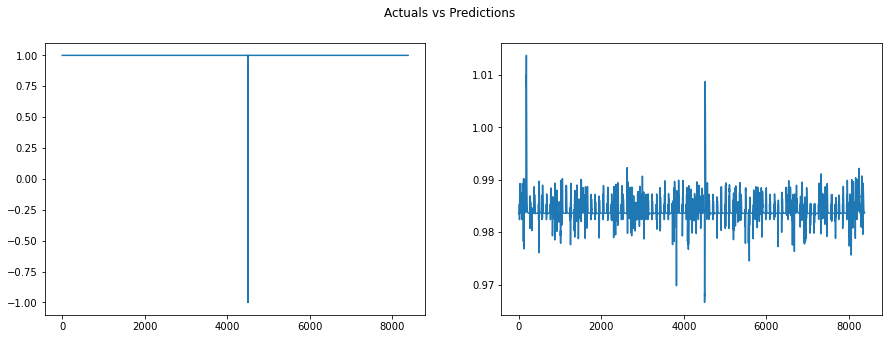

In [8]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 5)

fig.suptitle("Actuals vs Predictions")

ax[0].plot(new_channel.y_test[:, 0])

ax[1].plot(new_channel.y_hat)

### Class Plotter - visualize input data, predictions and errors

In [9]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(error))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

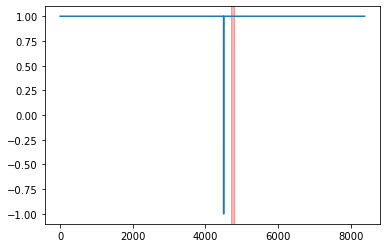

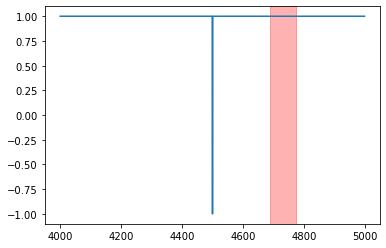

In [10]:
plotter = Plotter(new_channel)
plotter.plot_predictions()
plotter.plot_custom_range_predictions(4000, 5000)

### Calculate error between real and predicted data, create smoothed error

In [25]:
class ErrorWindow:
    def __init__(self, channel, e_s, window_size, window_number):
        self.channel = channel
        self.e_s = e_s
        self.window_num = window_number
        self.window_size = window_size
        self.E_seq = np.array([])
        
        self.mean = np.mean(self.e_s)
        self.std = np.std(self.e_s)
        self.epsilon = self.mean + 12 * self.std
        self.indices_anomalies = np.array([])
        # self.non_anom_max = np.max(self.e_s[self.e_s < self.epsilon])

    def calculate_epsilon(self):
        epsilon = 0
        max_score = float('-inf')

        for z in np.arange(2, 10, 0.5):
            epsilon = self.mean + (self.std * z)

            delta_mean = self.mean - np.mean(self.e_s[self.e_s < epsilon])
            delta_std = self.std - np.std(self.e_s[self.e_s < epsilon])
            e_a = self.e_s[self.e_s >= epsilon]

            if len(e_a) > 0:
                anom = np.argwhere(self.e_s >= epsilon).reshape(-1)
                E_seq =[list(g) for g in mit.consecutive_groups(anom)]
                E_seq_len = len(anom)
                
                score = ((delta_mean/self.mean) + (delta_std/self.std)) / (E_seq_len**2 + len(e_a))
                if score > max_score:
                    max_score = score
                    self.epsilon = epsilon
                    self.E_seq = E_seq
                    self.indices_anomalies = anom
                    # self.non_anom_max = np.max(self.e_s[self.e_s < self.epsilon])
        return epsilon

In [43]:
class Errors:
    def __init__(self, channel):
        self.channel = channel
        self.error = np.abs(channel.y_test[:, 0] - channel.y_hat)
        self.normalized = np.mean(self.error / np.ptp(channel.y_test))
        self.e_s = pd.DataFrame(self.error).ewm(span=105).mean().values.flatten()

        self.window_size = 30
        self.batch_size = 70

        self.n_windows = int((channel.y_test.shape[0] - (self.batch_size * self.window_size)) / self.batch_size)
        self.epsilons = []


    def detect_anomalies(self):

        for i in range(self.n_windows + 1):
            prior_idx = i * self.batch_size
            idx = self.window_size * self.batch_size + prior_idx

            window = ErrorWindow(self.channel, self.e_s[prior_idx:idx], self.window_size, i)
            self.epsilons.append(window.calculate_epsilon())

In [44]:
errors = Errors(new_channel)
errors.detect_anomalies()
epsilons = errors.epsilons

In [1]:
plt.plot(epsilons)
plt.show()
plotter.plot_threshold(errors.e_s, np.median(epsilons))
print(epsilons)
plt.show(  )
plotter.plot_predictions()

NameError: name 'plt' is not defined